In [1]:
import os
import cv2
import numpy as np

dataset_path = "/home/basma/Plant_Disease/dataset_tomato/"
IMG_SIZE = 128


def preprocess_image(img, filter_type="none"):

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    if filter_type == "gaussian":
        img = cv2.GaussianBlur(img, (5, 5), 0)
    elif filter_type == "median":
        img = cv2.medianBlur(img, 5)

    img = img / 255.0 
    return img

def load_dataset(dataset_path, filter_type="none"):
    data = []
    labels = []

    classes = os.listdir(dataset_path)
    classes.sort() 

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_image(img, filter_type)
            data.append(img)
            labels.append(i)

    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    return data, labels, classes

# Test du preprocessing
filters = ["none", "gaussian", "median"]

for f in filters:
    print("\n==============================")
    print("Filter:", f)
    data, labels, classes = load_dataset(dataset_path, filter_type=f)
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    print("Number of classes:", len(classes))
    print("Classes:", classes[:5])




Filter: none
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']

Filter: gaussian
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']

Filter: median
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']


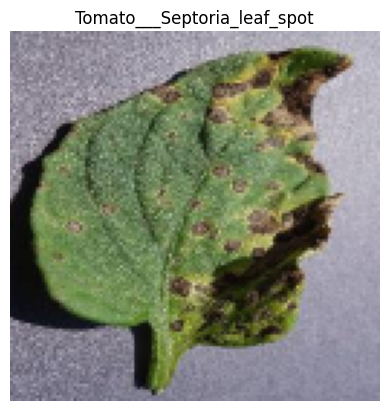

In [5]:
import matplotlib.pyplot as plt

data, labels, classes = load_dataset(dataset_path, filter_type="none")

index = 3455
plt.imshow(data[index])
plt.title(classes[labels[index]])
plt.axis("off")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# ===============================
# Construction du modèle CNN
# ===============================

EPOCHS = 10
BATCH_SIZE = 32

def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

2026-02-07 10:19:58.658008: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-07 10:19:58.669475: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-07 10:19:59.115326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-07 10:20:00.949883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [7]:

# ===============================
# Expériences avec filtres
# ===============================

results = {}

for f in filters:
    print("\n==============================")
    print("Training with filter:", f)
    # Charger dataset :
    data, labels, classes = load_dataset(dataset_path, filter_type=f)
    data, labels = shuffle(data, labels, random_state=42)

    # Split the data :
    X_train, X_temp, y_train, y_temp = train_test_split(
        data, labels, test_size=0.30, random_state=42)

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42)
    
    model = build_model(len(classes))
    model.summary()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    results[f] = test_acc
    print(f"Test accuracy with {f}: {test_acc:.4f}")


Training with filter: none


/home/basma/Plant_Disease/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-07 10:20:30.834647: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.4734 - loss: 1.2998 - val_accuracy: 0.7141 - val_loss: 0.7645
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.7877 - loss: 0.5756 - val_accuracy: 0.7453 - val_loss: 0.7075
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.8698 - loss: 0.3606 - val_accuracy: 0.8109 - val_loss: 0.5436
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9043 - loss: 0.2739 - val_accuracy: 0.8484 - val_loss: 0.4158
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.9484 - loss: 0.1531 - val_accuracy: 0.8391 - val_loss: 0.4855
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9742 - loss: 0.0875 - val_accuracy: 0.8406 - val_loss: 0.5197
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9816 - loss: 0.0643 - val_accuracy: 0.8469 - val_loss: 0.5018
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.9849 - loss: 0.0519 - val_accu

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.4928 - loss: 1.3280 - val_accuracy: 0.7000 - val_loss: 0.8265
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.7740 - loss: 0.6194 - val_accuracy: 0.7859 - val_loss: 0.5920
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.8591 - loss: 0.3793 - val_accuracy: 0.7875 - val_loss: 0.6419
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.8822 - loss: 0.3182 - val_accuracy: 0.8156 - val_loss: 0.5363
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.9247 - loss: 0.2200 - val_accuracy: 0.8266 - val_loss: 0.5466
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9531 - loss: 0.1464 - val_accuracy: 0.8313 - val_loss: 0.5323
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9689 - loss: 0.0986 - val_accuracy: 0.8391 - val_loss: 0.5759
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9739 - loss: 0.0801 - val_accu

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.5229 - loss: 1.2090 - val_accuracy: 0.7125 - val_loss: 0.8022
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.7958 - loss: 0.5504 - val_accuracy: 0.7828 - val_loss: 0.6013
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.8755 - loss: 0.3456 - val_accuracy: 0.7766 - val_loss: 0.6093
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.9263 - loss: 0.2272 - val_accuracy: 0.8484 - val_loss: 0.4504
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.9541 - loss: 0.1409 - val_accuracy: 0.8375 - val_loss: 0.5146
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.9739 - loss: 0.0834 - val_accuracy: 0.7922 - val_loss: 0.7810
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.9806 - loss: 0.0713 - val_accuracy: 0.8344 - val_loss: 0.6563
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9665 - loss: 0.0954 - val_accu

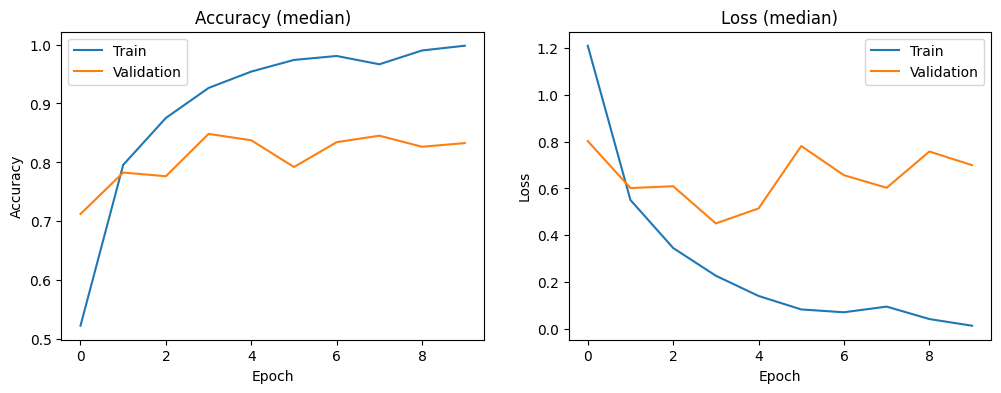

In [9]:

# ===============================
# Courbes Accuracy / Loss
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title(f'Accuracy ({f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title(f'Loss ({f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show() 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


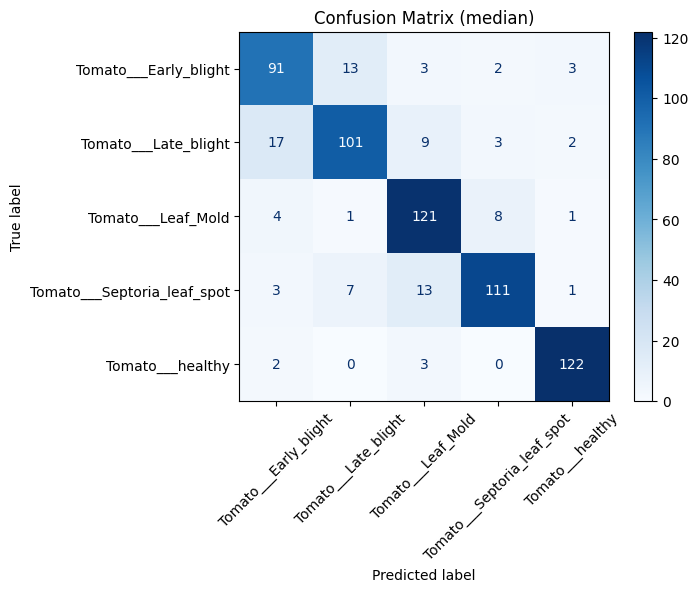

In [10]:
# ===============================
#  Matrice de confusion
# ===============================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
   
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix ({f})")
plt.show()

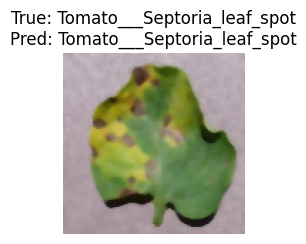

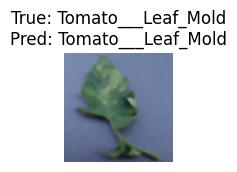

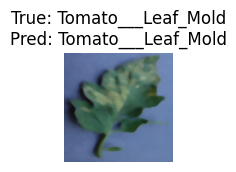

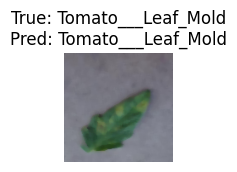

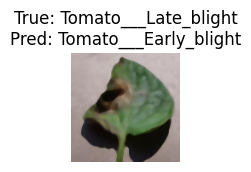

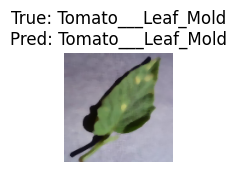

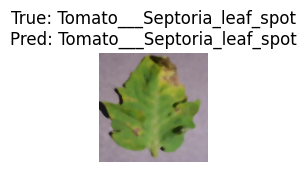

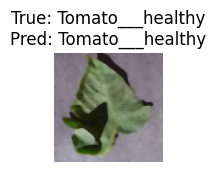

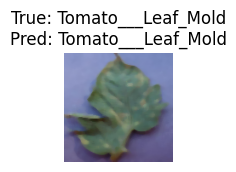

In [13]:
# ===============================
# Affichage prédictions aléatoires
# ===============================
import random
plt.figure(figsize=(8, 8))
for i in range(9):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred_classes[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

    plt.show()

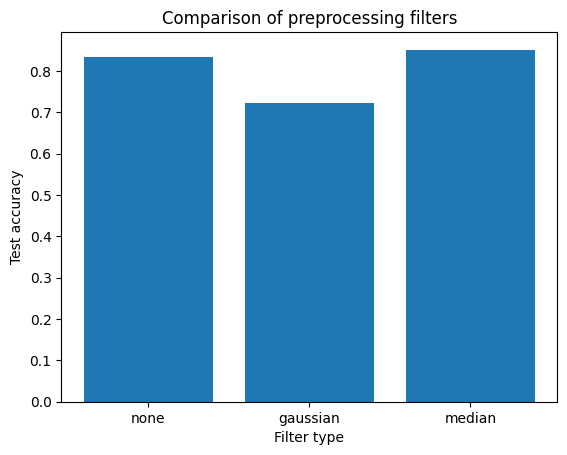


Final results:
none: 0.8331
gaussian: 0.7223
median: 0.8518


In [14]:

# ===============================
# Graphique comparaison finale
# ===============================
plt.figure()
plt.bar(results.keys(), results.values())
plt.xlabel("Filter type")
plt.ylabel("Test accuracy")
plt.title("Comparison of preprocessing filters")
plt.show()

print("\nFinal results:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

In [16]:
from tensorflow.keras.preprocessing import image

img_path = r"/home/basma/Plant_Disease/healthy.png"

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img = image.img_to_array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
predicted_class = classes[np.argmax(prediction)]

print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: Tomato___healthy
